In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import duckdb

In [2]:
_7037_final = '_7037_final_v3.db'
con = duckdb.connect(_7037_final)
con.execute("pragma threads=20")

In [3]:
msf = pd.read_parquet('crsp.msf_delisting_adjusted.parquet')
msf = pd.DataFrame(msf)
msf.sort_values(['permno', 'yearmonth'], inplace=True)
msf.reset_index(drop=True, inplace=True)
print(msf.shape)
print(msf.columns)

(4863765, 25)
Index(['cusip', 'permno', 'permco', 'issuno', 'hexcd', 'hsiccd', 'date',
       'bidlo', 'askhi', 'prc', 'vol', 'ret', 'bid', 'ask', 'shrout', 'cfacpr',
       'cfacshr', 'altprc', 'spread', 'altprcdt', 'retx', 'yearmonth', 'dlret',
       'ret_orig', 'shrcd'],
      dtype='object')


In [4]:
bm = pd.read_parquet('comp.finratios.parquet')
bm['gvkey']=bm['gvkey'].astype('int32')

In [5]:
bm.drop_duplicates(subset=['gvkey', 'public_date'], inplace=True)

In [6]:
bm.drop_duplicates(subset=['permno', 'public_date'], inplace=True)

In [7]:
bm['yearmonth_index'] = pd.to_datetime(bm['public_date']).dt.year * 12 + pd.to_datetime(bm['public_date']).dt.month + 1
msf['yearmonth_index'] = pd.to_datetime(msf['yearmonth']).dt.year * 12 + pd.to_datetime(msf['yearmonth']).dt.month

msf = con.execute('''
    select 
        msf.*,
        bm.gvkey, bm.bm
    from msf
    inner join bm
        on msf.permno = bm.permno
            and msf.yearmonth_index = bm.yearmonth_index
''').fetch_df()

msf.sort_values(['permno', 'yearmonth'], inplace=True)
msf.reset_index(drop=True, inplace=True)


In [8]:
'''
- 805,090 observations based on monthly return data from July 1997 to December 2012
- observations must have a one year history of past stock return data to compute momentum variables, 
- must have a stock price in the preceding month that is greater than one dollar. 
- FF–48 using value weighted peers
- TNIC–3 using equal weighted peers
'''
# for hoberg merge
msf['date'] = pd.to_datetime(msf['date'])
msf['year'] = msf['date'].dt.year
#
msf['prc_lag1'] = np.abs(msf.groupby('permno')['prc'].shift(1))
# for value weighted
msf['mcap'] = np.abs(msf['prc'] * msf['shrout'])
msf['mcap_lag1'] = msf.groupby(['permno'])['mcap'].shift(1)
# for table 1
msf['log_bm'] = np.log(msf['bm'])
msf['log_mcap'] = np.log(msf['mcap'])
msf['ret_lag1'] = msf.groupby(['permno'])['ret'].shift(1)

# filter
msf['rollvalidobs'] = (
    msf
    .assign(ret=msf['ret'].notnull())
    .groupby('permno')['ret']
    .rolling(12)
    .sum()
    .shift(1)
).reset_index([0], drop=True)

msf = msf[
    (
        (msf['yearmonth'] >= '1997-07') &
        (msf['yearmonth'] <= '2012-12') &
        (msf['shrcd'].isin(set([10,11]))) &
        (msf['prc_lag1'] > 1) &
        (msf['mcap_lag1'].notnull()) &
        (msf['rollvalidobs'] == 12)
    )
].reset_index(drop=True)

print(msf.shape)

(791949, 36)


In [9]:

sale = con.execute('''
    select 
        gvkey,
        cast(datadate as VARCHAR) as date,
        year(cast(cast(datadate as VARCHAR) as DATE)+365) as align_year,
        sale,
    from parquet_scan('comp.funda.parquet') as a
    where datafmt='STD' and indfmt='INDL' and consol='C' and popsrc='D'
''').fetch_df()

sale

,gvkey,date,align_year,sale
0,10751,1980-12-31,1981,82.247
1,10751,1981-12-31,1982,86.009
2,10751,1982-12-31,1983,66.322
3,10751,1983-12-31,1984,95.950
4,10751,1984-12-31,1985,120.782
...,...,...,...,...
545299,61712,2015-12-31,2016,20.943
545300,61712,2016-12-31,2017,22.506
545301,61788,1996-06-30,1997,53.958
545302,61712,2017-12-31,2018,23.283


In [10]:
# sale.dropna(inplace=True)
sale.sort_values(['gvkey', 'align_year'], inplace=True)
sale.drop_duplicates(subset=['gvkey', 'align_year'], keep='last', inplace=True) # keep the end of year sale, ignore the mid-year
sale.reset_index(drop=True, inplace=True)

In [11]:

msf = con.execute('''
    select 
        msf.*,
        sale.sale
    from msf
    inner join sale
        on msf.gvkey = sale.gvkey
            and msf.year = sale.align_year
''').fetch_df()


In [12]:
msf.duplicated(subset=['permno', 'yearmonth']).sum()

0

In [13]:
msf.duplicated(subset=['gvkey', 'yearmonth']).sum()

0

In [14]:
ff5 = pd.read_parquet('five_factor_monthly.parquet')
ff5 = pd.DataFrame(ff5)
ff3 = ff5.drop(['cma', 'rmw'], axis=1)

In [15]:
ff3.sort_values(['dt'])
ff3.reset_index(drop=True, inplace=True)
ff3.rename(columns={'dt':'date'}, inplace=True)
ff3['date'] = pd.to_datetime(ff3['date'])
ff3['date'] = ff3['date'].dt.strftime('%Y-%m')
ff3

,date,mkt_rf,smb,hml,rf
0,1963-07,-0.004027,-0.004313,-0.009794,0.002643
1,1963-08,0.050801,-0.007409,0.016690,0.002423
2,1963-09,-0.015728,-0.004244,0.000064,0.002804
3,1963-10,0.025101,-0.013001,0.000175,0.002994
4,1963-11,-0.008481,-0.010032,0.018485,0.002703
...,...,...,...,...,...
709,2022-08,-0.037878,0.016748,-0.000391,0.001842
710,2022-09,-0.093464,-0.010046,-0.001447,0.001892
711,2022-10,0.078120,0.016869,0.073117,0.002313
712,2022-11,0.046028,-0.025331,0.009260,0.002944


In [16]:
ff4 = pd.read_parquet('four_factor_monthly.parquet')
ff4 = pd.DataFrame(ff4)
ff4['ones'] = np.ones(len(ff4))
ff4.sort_values(['dt'])
ff4.reset_index(drop=True, inplace=True)
ff4.rename(columns={'dt':'date', 'mom': 'umd'}, inplace=True)
ff4['date'] = pd.to_datetime(ff4['date'])
ff4['date'] = ff4['date'].dt.strftime('%Y-%m')
ff4

,date,mkt_rf,smb,hml,rf,umd,ones
0,1926-07,0.028846,-0.025227,-0.023607,0.002252,NaN,1.0
1,1926-08,0.026697,-0.011477,0.037506,0.002603,NaN,1.0
2,1926-09,0.003724,-0.013688,0.000536,0.002162,NaN,1.0
3,1926-10,-0.033011,-0.001469,0.009004,0.003255,NaN,1.0
4,1926-11,0.025847,-0.001052,-0.006083,0.003125,NaN,1.0
...,...,...,...,...,...,...,...
1153,2022-08,-0.037878,0.015463,-0.000391,0.001842,0.001333,1.0
1154,2022-09,-0.093464,-0.007916,-0.001447,0.001892,0.046606,1.0
1155,2022-10,0.078120,0.001228,0.073117,0.002313,0.018421,1.0
1156,2022-11,0.046028,-0.030852,0.009260,0.002944,-0.028913,1.0


In [102]:
def rolling_prod(a, n=11) :
    ret = np.cumprod(a.values)
    ret[n:] = ret[n:] / ret[:-n]
    ret[:n-1] = np.nan
    return pd.Series(ret, index=a.index)

def checknull(group):
    if group.isnull().all():
        return True
    else:
        return False
    
def apply_quantiles(x, include_in_quantiles=None, bins=10): 
    x = pd.Series(x)
    if include_in_quantiles is None:
        include_in_quantiles = [True] * len(x)        
    
    quantiles = np.quantile(
#         x[x.notnull() & include_in_quantiles],
        np.unique(x[x.notnull() & include_in_quantiles]),
        np.linspace(0, 1, bins+1)
    )
    quantiles[0] = x.dropna().min() - 1
    quantiles[-1] = x.dropna().max() + 1    
    return pd.cut(x, quantiles, labels=False) + 1

def table1(df):
    return df.mean(), df.std(), df.min(), df.median(), df.max()


def table11(df, yvar):
    xvars = ['ones', 'mkt_rf', 'hml', 'smb', 'umd']
    df_ff3 = con.execute('''
        select * 
        from df
        inner join ff4
            on df.date = ff4.date
        order by df.date
    ''').fetch_df()
    reg = sm.OLS(df_ff3[yvar], df_ff3[xvars]).fit()
    return reg.params[0], reg.params[1], reg.params[2], reg.params[3], reg.params[4], np.sqrt(12) * df[yvar].mean() / df[yvar].std(), reg.rsquared, len(df_ff3)


In [18]:
def make_portfolio(df): # keep date, bin, ret 
    
    portfolios = (
        df[
            df['bin'].notnull() &
            df['ret'].notnull() 
        ]
        .groupby(['bin', 'date'])[['ret', 'mcap_lag1']]
        .apply(
            lambda g: pd.Series({
                'ew': g['ret'].mean(),
                'vw': np.average(g['ret'], weights=g['mcap_lag1'])
            })
        )
        .reset_index()
    )
    
    portfolio_table11 = (
        portfolios[portfolios['bin'].isin(set([1, 10]))]
        .groupby('date')
        .apply(
            lambda g: pd.Series({
                'ew_short': np.sum(np.where(g['bin']==1, -g['ew'], 0)),
                'ew_long': np.sum(np.where(g['bin']==10, g['ew'], 0))
            })
        )
        .reset_index()
    )

    portfolio_LS = (
        portfolios[portfolios['bin'].isin(set([1, 10]))]
        .groupby('date')
        .apply(
            lambda g: pd.Series({
                'ew': np.sum(np.where(g['bin']==1, -g['ew'], g['ew'])),
                'vw': np.sum(np.where(g['bin']==1, -g['vw'], g['vw']))
            })
        )
        .reset_index()
    )
        
    portfolio_LS = portfolio_LS.sort_values('date').reset_index(drop=True)
    portfolio_LS['cum_ew'] = (portfolio_LS['ew'] + 1).cumprod()
    portfolio_LS['cum_vw'] = (portfolio_LS['vw'] + 1).cumprod()

    
    portfolio_ff3 = con.execute('''
        select
            portfolio_LS.*,
            ff3.mkt_rf, ff3.smb, ff3.hml
        from portfolio_LS
        join ff3
            on portfolio_LS.date = ff3.date
        order by portfolio_LS.date
    ''').fetch_df()

    xvars = ['mkt_rf', 'smb', 'hml']
    yvar = ['ew']
    tmp = RollingOLS(portfolio_ff3[yvar], portfolio_ff3[xvars], window=30, expanding=False).fit(params_only=True)
    portfolio_ff3['alpha_ew'] = portfolio_ff3[yvar].values - np.expand_dims((portfolio_ff3[xvars].values * tmp.params.values).sum(axis=1), axis=1)
    portfolio_ff3['cum_alpha_ew'] = (portfolio_ff3['alpha_ew'] + 1).cumprod()
    
    yvar = ['vw']
    tmp = RollingOLS(portfolio_ff3[yvar], portfolio_ff3[xvars], window=30, expanding=False).fit(params_only=True)
    portfolio_ff3['alpha_vw'] = portfolio_ff3[yvar].values - np.expand_dims((portfolio_ff3[xvars].values * tmp.params.values).sum(axis=1), axis=1)
    portfolio_ff3['cum_alpha_vw'] = (portfolio_ff3['alpha_vw'] + 1).cumprod()
    
    return portfolio_ff3, portfolio_table11


# own-firm

In [19]:
own_firm = msf.copy()

own_firm = own_firm[['permno', 'yearmonth', 'ret', 'mcap_lag1']]
own_firm.rename(columns={'yearmonth':'date'}, inplace=True)
own_firm.sort_values(['permno', 'date'], inplace=True)
own_firm.reset_index(drop=True, inplace=True)

own_firm

,permno,date,ret,mcap_lag1
0,10001.0,1997-07,0.045455,1.944525e+04
1,10001.0,1997-08,0.014493,2.032912e+04
2,10001.0,1997-09,0.026857,2.062375e+04
3,10001.0,1997-10,0.000000,2.110475e+04
4,10001.0,1997-11,-0.014085,2.110475e+04
...,...,...,...,...
789891,93436.0,2012-08,0.040117,2.890945e+06
789892,93436.0,2012-09,0.026648,3.006921e+06
789893,93436.0,2012-10,-0.039228,3.097004e+06
789894,93436.0,2012-11,0.202215,3.200762e+06


In [20]:
own_firm['rollret_11'] = (
    own_firm
    .assign(ret=(own_firm['ret'].fillna(0)+1))
    .groupby('permno')['ret']
    .apply(rolling_prod)
) - 1

own_firm['momentum'] = own_firm.groupby('permno')['rollret_11'].shift(2)
own_firm['rollret_11'] = own_firm.groupby('permno')['rollret_11'].shift(2)
own_firm

/var/folders/4p/lng78s416xs7hybsq7jh6lqm0000gn/T/ipykernel_6926/2717053250.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  own_firm


,permno,date,ret,mcap_lag1,rollret_11,momentum
0,10001.0,1997-07,0.045455,1.944525e+04,NaN,NaN
1,10001.0,1997-08,0.014493,2.032912e+04,NaN,NaN
2,10001.0,1997-09,0.026857,2.062375e+04,NaN,NaN
3,10001.0,1997-10,0.000000,2.110475e+04,NaN,NaN
4,10001.0,1997-11,-0.014085,2.110475e+04,NaN,NaN
...,...,...,...,...,...,...
789891,93436.0,2012-08,0.040117,2.890945e+06,NaN,NaN
789892,93436.0,2012-09,0.026648,3.006921e+06,0.108327,0.108327
789893,93436.0,2012-10,-0.039228,3.097004e+06,0.169332,0.169332
789894,93436.0,2012-11,0.202215,3.200762e+06,-0.003064,-0.003064


In [21]:
own_firm['check'] = own_firm.groupby('date')['momentum'].transform(checknull)
check123333 = own_firm[own_firm['check']==True]
print(min(own_firm['date']))
print(min(check123333['date']))
print(max(check123333['date']))

1997-07
1997-07
1998-06


In [22]:
own_firm.duplicated(subset=['permno', 'date']).sum()

0

In [23]:
own_firm = own_firm[own_firm['momentum'].notnull()]

In [24]:
own_firm['bin'] = (
    own_firm
    .groupby('date')
    .apply(lambda group: apply_quantiles(group['momentum'], bins=10))
).reset_index(level=[0], drop=True).sort_index()

own_firm

/var/folders/4p/lng78s416xs7hybsq7jh6lqm0000gn/T/ipykernel_6926/1169111209.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  own_firm['bin'] = (


,permno,date,ret,mcap_lag1,rollret_11,momentum,check,bin
12,10001.0,1998-07,0.014493,2.072588e+04,0.092678,0.092678,False,4
13,10001.0,1998-08,0.000000,2.102625e+04,0.051486,0.051486,False,5
14,10001.0,1998-09,0.070286,2.102625e+04,0.051486,0.051486,False,6
15,10001.0,1998-10,0.000000,2.226475e+04,0.023985,0.023985,False,8
16,10001.0,1998-11,0.020270,2.226475e+04,0.095956,0.095956,False,8
...,...,...,...,...,...,...,...,...
789873,93434.0,2012-12,0.037634,5.857512e+04,0.720408,0.720408,False,10
789892,93436.0,2012-09,0.026648,3.006921e+06,0.108327,0.108327,False,6
789893,93436.0,2012-10,-0.039228,3.097004e+06,0.169332,0.169332,False,5
789894,93436.0,2012-11,0.202215,3.200762e+06,-0.003064,-0.003064,False,4


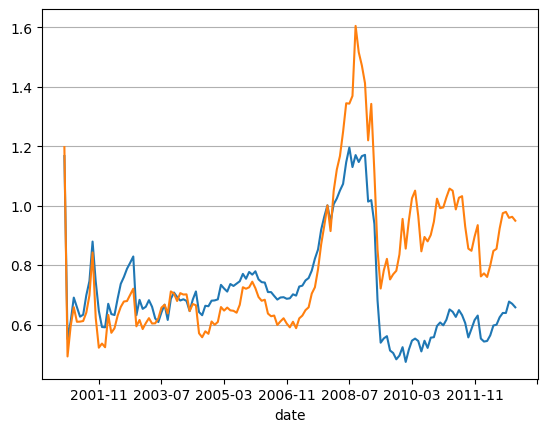

In [25]:

portfolio_ff3_own_firm, portfolio_table11_own_firm = make_portfolio(own_firm)

portfolio_ff3_own_firm.set_index('date')['cum_alpha_ew'].plot().grid(axis='y')
portfolio_ff3_own_firm.set_index('date')['cum_alpha_vw'].plot().grid(axis='y')

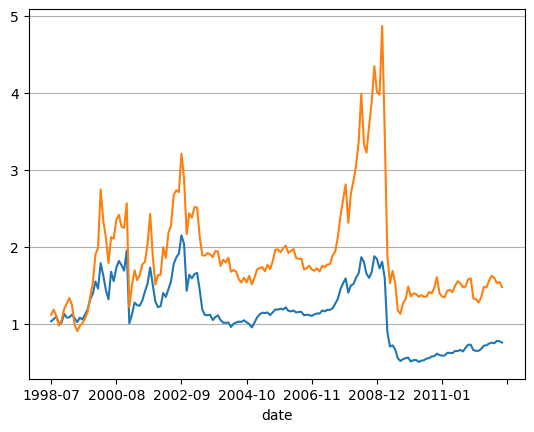

In [26]:
portfolio_ff3_own_firm.set_index('date')['cum_ew'].plot().grid(axis='y')
portfolio_ff3_own_firm.set_index('date')['cum_vw'].plot().grid(axis='y')

# TNIC

In [27]:
hoberg = pd.read_parquet('hoberg_cross_firm_similarity_permno.parquet')
hoberg = pd.DataFrame(hoberg)
#permno1 is the focal firm
hoberg

,permno1,permno2,year,similarity_score
0,12045.0,10149.0,1992,0.0226
1,83693.0,86822.0,2001,0.0294
2,12068.0,91400.0,2014,0.1458
3,76581.0,79233.0,1994,0.0160
4,75551.0,84276.0,1993,0.0658
...,...,...,...,...
23856530,50412.0,77307.0,1992,0.0400
23856531,83657.0,82598.0,1998,0.0327
23856532,76198.0,59408.0,1990,0.0200
23856533,86714.0,84351.0,1996,0.1020


In [28]:

con.execute('''
    create or replace table hoberg_msf as
    select 
        hoberg.permno1 as permno,
        msf.yearmonth, msf.permno as paired_permno, msf.ret as paired_ret
    from hoberg
    inner join msf
        on hoberg.permno2 = msf.permno 
            and hoberg.year = msf.year
    where msf.yearmonth between '1997-07' and '2012-12'
''')


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

In [29]:
con.execute('''
    select *
    from hoberg_msf
    order by permno, yearmonth, paired_permno
    limit 100
''').fetch_df()

,permno,yearmonth,paired_permno,paired_ret
0,10001.0,1997-07,10001.0,0.045455
1,10001.0,1997-07,10823.0,0.062969
2,10001.0,1997-07,11170.0,0.060855
3,10001.0,1997-07,11674.0,0.081448
4,10001.0,1997-07,12781.0,0.080460
...,...,...,...,...
95,10001.0,1997-08,17929.0,0.075533
96,10001.0,1997-08,19546.0,0.113636
97,10001.0,1997-08,21231.0,-0.014528
98,10001.0,1997-08,21776.0,0.032447


In [30]:
con.execute('''
    create or replace table hm as
    select
        permno, yearmonth,
        avg(paired_ret) as peer_ret
    from hoberg_msf
    group by permno, yearmonth
    order by permno, yearmonth
''')

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

In [31]:
con.execute('''
    select *
    from hm
    limit 100
''').fetch_df()

,permno,yearmonth,peer_ret
0,10001.0,1997-07,0.024666
1,10001.0,1997-08,0.003059
2,10001.0,1997-09,0.036272
3,10001.0,1997-10,0.001866
4,10001.0,1997-11,0.051278
...,...,...,...
95,10001.0,2005-06,0.052317
96,10001.0,2005-07,0.039036
97,10001.0,2005-08,0.013343
98,10001.0,2005-09,0.029156


In [32]:
con.execute('''
    create or replace table hm_1 as
    select 
        hm.permno, hm.yearmonth, hm.peer_ret, 
        msf.ret, msf.mcap_lag1
    from hm
    inner join msf
        on hm.permno = msf.permno
            and hm.yearmonth = msf.yearmonth
    order by hm.permno, hm.yearmonth
''')

In [33]:
hm_1 = con.execute('''
    select *
    from hm_1
''').fetch_df()

hm_1

,permno,yearmonth,peer_ret,ret,mcap_lag1
0,10001.0,1997-07,0.024666,0.045455,1.944525e+04
1,10001.0,1997-08,0.003059,0.014493,2.032912e+04
2,10001.0,1997-09,0.036272,0.026857,2.062375e+04
3,10001.0,1997-10,0.001866,0.000000,2.110475e+04
4,10001.0,1997-11,0.051278,-0.014085,2.110475e+04
...,...,...,...,...,...
748763,93436.0,2012-08,0.051262,0.040117,2.890945e+06
748764,93436.0,2012-09,-0.004501,0.026648,3.006921e+06
748765,93436.0,2012-10,0.008531,-0.039228,3.097004e+06
748766,93436.0,2012-11,0.051827,0.202215,3.200762e+06


In [34]:
hm_1.rename(columns={'yearmonth':'date'}, inplace=True)

In [35]:
hm_1['rollret_12'] = (
    hm_1
    .assign(peer_ret=(hm_1['peer_ret'].fillna(0)+1))
    .groupby('permno')['peer_ret']
    .apply(lambda g: rolling_prod(g, n=12)) # 
) - 1

hm_1['rollret_6'] = (
    hm_1
    .assign(peer_ret=(hm_1['peer_ret'].fillna(0)+1))
    .groupby('permno')['peer_ret']
    .apply(lambda g: rolling_prod(g, n=6)) # 
) - 1

hm_1['rollret_3'] = (
    hm_1
    .assign(peer_ret=(hm_1['peer_ret'].fillna(0)+1))
    .groupby('permno')['peer_ret']
    .apply(lambda g: rolling_prod(g, n=3)) # 
) - 1

hm_1['rollret_1'] = (
    hm_1['peer_ret'].fillna(0)
)

hm_1['momentum'] = hm_1.groupby('permno')['rollret_12'].shift(1)
hm_1['rollret_12'] = hm_1.groupby('permno')['rollret_12'].shift(1)
hm_1['rollret_6'] = hm_1.groupby('permno')['rollret_6'].shift(1)
hm_1['rollret_3'] = hm_1.groupby('permno')['rollret_3'].shift(1)
hm_1['rollret_1'] = hm_1.groupby('permno')['rollret_1'].shift(1)
hm_1

/var/folders/4p/lng78s416xs7hybsq7jh6lqm0000gn/T/ipykernel_6926/2526230645.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  hm_1
/var/folders/4p/lng78s416xs7hybsq7jh6lqm0000gn/T/ipykernel_6926/2526230645.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  hm_1
/var/folders/4p/lng78s416xs7hybs

,permno,date,peer_ret,ret,mcap_lag1,rollret_12,rollret_6,rollret_3,rollret_1,momentum
0,10001.0,1997-07,0.024666,0.045455,1.944525e+04,NaN,NaN,NaN,NaN,NaN
1,10001.0,1997-08,0.003059,0.014493,2.032912e+04,NaN,NaN,NaN,0.024666,NaN
2,10001.0,1997-09,0.036272,0.026857,2.062375e+04,NaN,NaN,NaN,0.003059,NaN
3,10001.0,1997-10,0.001866,0.000000,2.110475e+04,NaN,NaN,0.065081,0.036272,NaN
4,10001.0,1997-11,0.051278,-0.014085,2.110475e+04,NaN,NaN,0.041382,0.001866,NaN
...,...,...,...,...,...,...,...,...,...,...
748763,93436.0,2012-08,0.051262,0.040117,2.890945e+06,NaN,-0.115170,-0.114778,-0.097862,NaN
748764,93436.0,2012-09,-0.004501,0.026648,3.006921e+06,-0.307661,-0.142295,0.009039,0.051262,-0.307661
748765,93436.0,2012-10,0.008531,-0.039228,3.097004e+06,-0.199105,-0.169496,-0.055886,-0.004501,-0.199105
748766,93436.0,2012-11,0.051827,0.202215,3.200762e+06,-0.271638,-0.065685,0.055458,0.008531,-0.271638


In [36]:
hm_1['check'] = hm_1.groupby('date')['momentum'].transform(checknull)
check123333 = hm_1[hm_1['check']==True]

print(min(hm_1['date']))
print(min(check123333['date']))
print(max(check123333['date']))

1997-07
1997-07
1998-06


In [37]:
hm_1.duplicated(subset=['permno', 'date']).sum()

0

In [38]:
hm_1 = hm_1[hm_1['momentum'].notnull()]

In [39]:
hm_1['bin'] = (
    hm_1
    .groupby('date')
    .apply(lambda group: apply_quantiles(group['momentum'], bins=10))
).reset_index(level=[0], drop=True).sort_index()

hm_1

/var/folders/4p/lng78s416xs7hybsq7jh6lqm0000gn/T/ipykernel_6926/2142527327.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hm_1['bin'] = (


,permno,date,peer_ret,ret,mcap_lag1,rollret_12,rollret_6,rollret_3,rollret_1,momentum,check,bin
12,10001.0,1998-07,-0.053732,0.014493,2.072588e+04,0.232910,-0.000302,-0.017553,0.018993,0.232910,False,6
13,10001.0,1998-08,-0.027233,0.000000,2.102625e+04,0.138579,-0.010041,-0.057189,-0.053732,0.138579,False,6
14,10001.0,1998-09,0.094271,0.070286,2.102625e+04,0.104194,-0.052754,-0.062020,-0.027233,0.104194,False,9
15,10001.0,1998-10,0.004033,0.000000,2.226475e+04,0.165994,-0.010406,0.007274,0.094271,0.165994,False,10
16,10001.0,1998-11,0.019319,0.020270,2.226475e+04,0.168516,0.007642,0.068764,0.004033,0.168516,False,10
...,...,...,...,...,...,...,...,...,...,...,...,...
748748,93434.0,2012-12,0.010779,0.037634,5.857512e+04,0.226924,0.170559,0.094672,-0.080992,0.226924,False,7
748764,93436.0,2012-09,-0.004501,0.026648,3.006921e+06,-0.307661,-0.142295,0.009039,0.051262,-0.307661,False,1
748765,93436.0,2012-10,0.008531,-0.039228,3.097004e+06,-0.199105,-0.169496,-0.055886,-0.004501,-0.199105,False,1
748766,93436.0,2012-11,0.051827,0.202215,3.200762e+06,-0.271638,-0.065685,0.055458,0.008531,-0.271638,False,1


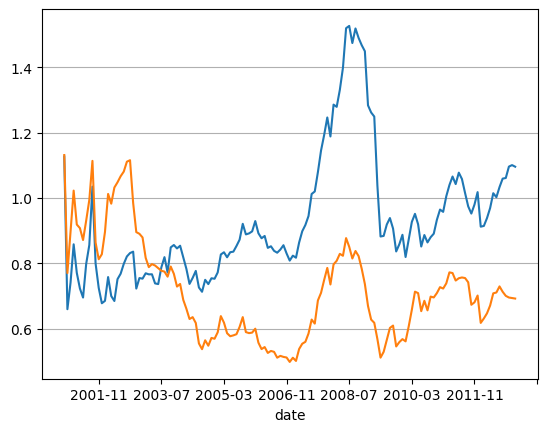

In [40]:
portfolio_ff3_hm, portfolio_table11_hm= make_portfolio(hm_1)

portfolio_ff3_hm.set_index('date')['cum_alpha_ew'].plot().grid(axis='y')
portfolio_ff3_hm.set_index('date')['cum_alpha_vw'].plot().grid(axis='y')

# SIC

In [41]:
SIC = pd.read_parquet('ff49.parquet')
SIC = pd.DataFrame(SIC)

SIC

,ff49,name,subname,sic_int,sic
0,1,1 Agric Agriculture,Agric production - crops,100,0100
1,1,1 Agric Agriculture,Agric production - crops,101,0101
2,1,1 Agric Agriculture,Agric production - crops,102,0102
3,1,1 Agric Agriculture,Agric production - crops,103,0103
4,1,1 Agric Agriculture,Agric production - crops,104,0104
...,...,...,...,...,...
5049,49,49 Other Almost Nothing,"Steam, air conditioning supplies",4961,4961
5050,49,49 Other Almost Nothing,Irrigation systems,4970,4970
5051,49,49 Other Almost Nothing,Irrigation systems,4971,4971
5052,49,49 Other Almost Nothing,Cogeneration - SM power producer,4990,4990


In [42]:

con.execute('''
    create or replace table SIC_msf as
    select 
        msf.permno, msf.yearmonth, msf.ret, msf.mcap_lag1,
        SIC.ff49
    from msf
    inner join SIC
        on SIC.sic_int = msf.hsiccd
    where msf.yearmonth between '1997-07' and '2012-12'
''')


In [43]:
con.execute('''
    select *
    from SIC_msf
    order by permno, yearmonth
    limit 100
''').fetch_df()

,permno,yearmonth,ret,mcap_lag1,ff49
0,10001.0,1997-07,0.045455,19445.250000,31
1,10001.0,1997-08,0.014493,20329.125000,31
2,10001.0,1997-09,0.026857,20623.750000,31
3,10001.0,1997-10,0.000000,21104.750000,31
4,10001.0,1997-11,-0.014085,21104.750000,31
...,...,...,...,...,...
95,10001.0,2005-06,0.128429,21052.501202,31
96,10001.0,2005-07,0.009945,26362.650556,31
97,10001.0,2005-08,0.039387,26624.821000,31
98,10001.0,2005-09,0.211579,27673.500000,31


In [44]:
con.execute('''
    create or replace table SIC_msf_1 as
    select 
        SIC_msf.permno, SIC_msf.yearmonth, SIC_msf.ret, SIC_msf.mcap_lag1,
        SIC_msf_copy.permno as paired_permno,
        SIC_msf_copy.ret as paired_ret,
        SIC_msf_copy.mcap_lag1 as paired_mcap_lag1
    from SIC_msf
    inner join SIC_msf SIC_msf_copy
        on SIC_msf.ff49 = SIC_msf_copy.ff49
        and SIC_msf.yearmonth = SIC_msf_copy.yearmonth
        and SIC_msf.permno != SIC_msf_copy.permno
''')

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

In [45]:
con.execute('''
    select *
    from SIC_msf_1
    order by permno, yearmonth
    limit 100
''').fetch_df()

,permno,yearmonth,ret,mcap_lag1,paired_permno,paired_ret,paired_mcap_lag1
0,10001.0,1997-07,0.045455,19445.25,64290.0,0.025070,2.533418e+05
1,10001.0,1997-07,0.045455,19445.25,24360.0,0.067935,2.782701e+06
2,10001.0,1997-07,0.045455,19445.25,58334.0,0.004296,5.947705e+05
3,10001.0,1997-07,0.045455,19445.25,58406.0,-0.127907,3.836030e+05
4,10001.0,1997-07,0.045455,19445.25,18411.0,0.017714,1.491164e+07
...,...,...,...,...,...,...,...
95,10001.0,1997-07,0.045455,19445.25,82855.0,-0.079646,4.254379e+05
96,10001.0,1997-07,0.045455,19445.25,81192.0,-0.044534,3.778482e+05
97,10001.0,1997-07,0.045455,19445.25,81058.0,-0.003752,8.655254e+05
98,10001.0,1997-07,0.045455,19445.25,53663.0,0.119433,4.353684e+05


In [46]:
con.execute('''
    create or replace table sm as
    select
        permno, yearmonth, ret, mcap_lag1,
        (sum(paired_ret * paired_mcap_lag1) / sum(paired_mcap_lag1)) as peer_ret
    from SIC_msf_1
    group by permno, yearmonth, ret, mcap_lag1
    order by permno, yearmonth, ret, mcap_lag1
''')

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

In [47]:
con.execute('''
    select *
    from sm
    limit 100
''').fetch_df()

,permno,yearmonth,ret,mcap_lag1,peer_ret
0,10001.0,1997-07,0.045455,19445.250000,0.027718
1,10001.0,1997-08,0.014493,20329.125000,-0.017421
2,10001.0,1997-09,0.026857,20623.750000,0.047876
3,10001.0,1997-10,0.000000,21104.750000,0.009748
4,10001.0,1997-11,-0.014085,21104.750000,0.071570
...,...,...,...,...,...
95,10001.0,2005-06,0.128429,21052.501202,0.055875
96,10001.0,2005-07,0.009945,26362.650556,0.028585
97,10001.0,2005-08,0.039387,26624.821000,0.007227
98,10001.0,2005-09,0.211579,27673.500000,0.035872


In [48]:
sm_1 = con.execute('''
    select *
    from sm
''').fetch_df()

sm_1

,permno,yearmonth,ret,mcap_lag1,peer_ret
0,10001.0,1997-07,0.045455,19445.250000,0.027718
1,10001.0,1997-08,0.014493,20329.125000,-0.017421
2,10001.0,1997-09,0.026857,20623.750000,0.047876
3,10001.0,1997-10,0.000000,21104.750000,0.009748
4,10001.0,1997-11,-0.014085,21104.750000,0.071570
...,...,...,...,...,...
784659,93435.0,2011-11,-0.050420,28398.161366,-0.054446
784660,93435.0,2011-12,-0.115044,26966.319886,0.030338
784661,93435.0,2012-02,0.181102,30307.279545,0.062996
784662,93435.0,2012-03,0.793333,35796.000000,0.105440


In [49]:
sm_1.rename(columns={'yearmonth':'date'}, inplace=True)

In [50]:
sm_1['rollret_12'] = (
    sm_1
    .assign(peer_ret=(sm_1['peer_ret'].fillna(0)+1))
    .groupby('permno')['peer_ret']
    .apply(lambda g: rolling_prod(g, n=12)) # 
) - 1

sm_1['rollret_6'] = (
    sm_1
    .assign(peer_ret=(sm_1['peer_ret'].fillna(0)+1))
    .groupby('permno')['peer_ret']
    .apply(lambda g: rolling_prod(g, n=6)) # 
) - 1

sm_1['rollret_3'] = (
    sm_1
    .assign(peer_ret=(sm_1['peer_ret'].fillna(0)+1))
    .groupby('permno')['peer_ret']
    .apply(lambda g: rolling_prod(g, n=3)) # 
) - 1

sm_1['rollret_1'] = (
    sm_1['peer_ret'].fillna(0)
) 

sm_1['momentum'] = sm_1.groupby('permno')['rollret_12'].shift(1)
sm_1['rollret_12'] = sm_1.groupby('permno')['rollret_12'].shift(1)
sm_1['rollret_6'] = sm_1.groupby('permno')['rollret_6'].shift(1)
sm_1['rollret_3'] = sm_1.groupby('permno')['rollret_3'].shift(1)
sm_1['rollret_1'] = sm_1.groupby('permno')['rollret_1'].shift(1)
sm_1


/var/folders/4p/lng78s416xs7hybsq7jh6lqm0000gn/T/ipykernel_6926/4245085926.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  sm_1
/var/folders/4p/lng78s416xs7hybsq7jh6lqm0000gn/T/ipykernel_6926/4245085926.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  sm_1
/var/folders/4p/lng78s416xs7hybs

,permno,date,ret,mcap_lag1,peer_ret,rollret_12,rollret_6,rollret_3,rollret_1,momentum
0,10001.0,1997-07,0.045455,19445.250000,0.027718,NaN,NaN,NaN,NaN,NaN
1,10001.0,1997-08,0.014493,20329.125000,-0.017421,NaN,NaN,NaN,0.027718,NaN
2,10001.0,1997-09,0.026857,20623.750000,0.047876,NaN,NaN,NaN,-0.017421,NaN
3,10001.0,1997-10,0.000000,21104.750000,0.009748,NaN,NaN,0.058160,0.047876,NaN
4,10001.0,1997-11,-0.014085,21104.750000,0.071570,NaN,NaN,0.039658,0.009748,NaN
...,...,...,...,...,...,...,...,...,...,...
784659,93435.0,2011-11,-0.050420,28398.161366,-0.054446,NaN,NaN,NaN,-0.128154,NaN
784660,93435.0,2011-12,-0.115044,26966.319886,0.030338,NaN,NaN,NaN,-0.054446,NaN
784661,93435.0,2012-02,0.181102,30307.279545,0.062996,NaN,NaN,-0.150613,0.030338,NaN
784662,93435.0,2012-03,0.793333,35796.000000,0.105440,NaN,NaN,0.035613,0.062996,NaN


In [51]:
sm_1['check'] = sm_1.groupby('date')['momentum'].transform(checknull)
check123333 = sm_1[sm_1['check']==True]
check123333
print(min(sm_1['date']))
print(min(check123333['date']))
print(max(check123333['date']))

1997-07
1997-07
1998-06


In [52]:
sm_1.duplicated(subset=['permno', 'date']).sum()

0

In [53]:
sm_1 = sm_1[sm_1['momentum'].notnull()]

In [54]:
sm_1['bin'] = (
    sm_1
    .groupby('date')
    .apply(lambda group: apply_quantiles(group['momentum'], bins=10))
).reset_index(level=[0], drop=True).sort_index()

sm_1

/var/folders/4p/lng78s416xs7hybsq7jh6lqm0000gn/T/ipykernel_6926/1682406565.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sm_1['bin'] = (


,permno,date,ret,mcap_lag1,peer_ret,rollret_12,rollret_6,rollret_3,rollret_1,momentum,check,bin
12,10001.0,1998-07,0.014493,2.072588e+04,-0.055464,0.304514,0.053296,-0.005070,0.033036,0.304514,False,6
13,10001.0,1998-08,0.000000,2.102625e+04,0.013863,0.198929,0.036292,-0.038996,-0.055464,0.198929,False,6
14,10001.0,1998-09,0.070286,2.102625e+04,0.086494,0.237100,0.022465,-0.010734,0.013863,0.237100,False,10
15,10001.0,1998-10,0.000000,2.226475e+04,-0.020129,0.282692,0.035183,0.040458,0.086494,0.282692,False,10
16,10001.0,1998-11,0.020270,2.226475e+04,0.018127,0.244739,0.037291,0.079382,-0.020129,0.244739,False,8
...,...,...,...,...,...,...,...,...,...,...,...,...
784641,93426.0,2012-12,0.083607,1.506212e+05,0.032093,0.011948,0.025483,-0.037447,0.036601,0.011948,False,1
784654,93429.0,2012-09,0.033755,2.482016e+06,0.041836,0.134577,0.017751,0.086069,0.033224,0.134577,False,4
784655,93429.0,2012-10,0.002381,2.565797e+06,0.004299,0.319609,0.008472,0.086446,0.041836,0.319609,False,6
784656,93429.0,2012-11,0.022396,2.571906e+06,-0.003287,0.190663,0.039816,0.081078,0.004299,0.190663,False,6


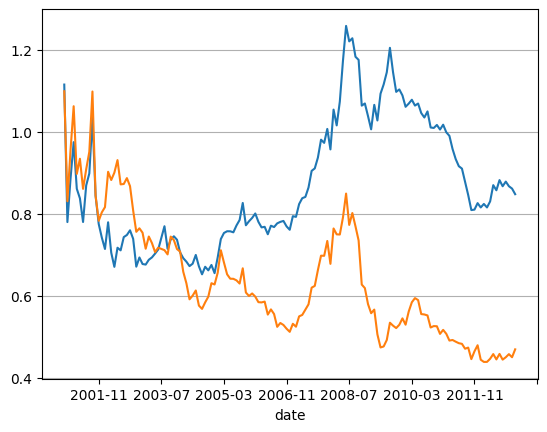

In [55]:
portfolio_ff3_sm, portfolio_table11_sm = make_portfolio(sm_1)

portfolio_ff3_sm.set_index('date')['cum_alpha_ew'].plot().grid(axis='y')
portfolio_ff3_sm.set_index('date')['cum_alpha_vw'].plot().grid(axis='y')

# High disparity

In [56]:

con.execute('''
    create or replace table hoberg_msf_sales as
    select 
        hoberg.permno1 as permno,
        msf.yearmonth, msf.permno as paired_permno, msf.sale as paired_sales
    from hoberg
    inner join msf
        on hoberg.permno2 = msf.permno 
            and hoberg.year = msf.year
    where msf.yearmonth between '1997-07' and '2012-12'
''')


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

In [57]:

con.execute('''
    select *
    from hoberg_msf_sales
    order by permno, yearmonth, paired_permno
    limit 100
''').fetch_df()

,permno,yearmonth,paired_permno,paired_sales
0,10001.0,1997-07,10001.0,31.318
1,10001.0,1997-07,10823.0,1432.002
2,10001.0,1997-07,11170.0,570.061
3,10001.0,1997-07,11674.0,3645.400
4,10001.0,1997-07,12781.0,548.086
...,...,...,...,...
95,10001.0,1997-08,17929.0,1557.600
96,10001.0,1997-08,19546.0,65.911
97,10001.0,1997-08,21231.0,969.778
98,10001.0,1997-08,21776.0,4283.648


In [58]:

con.execute('''
    create or replace table SIC_msf_sales as
    select 
        msf.permno, msf.yearmonth, msf.sale,
        SIC.ff49
    from msf
    inner join SIC
        on SIC.sic_int = msf.hsiccd
    where msf.yearmonth between '1997-07' and '2012-12'
''')


In [59]:
con.execute('''
    select *
    from SIC_msf_sales
    order by permno, yearmonth, ff49
    limit 100
''').fetch_df()

,permno,yearmonth,sale,ff49
0,10001.0,1997-07,31.318,31
1,10001.0,1997-08,31.318,31
2,10001.0,1997-09,31.318,31
3,10001.0,1997-10,31.318,31
4,10001.0,1997-11,31.318,31
...,...,...,...,...
95,10001.0,2005-06,73.291,31
96,10001.0,2005-07,73.291,31
97,10001.0,2005-08,73.291,31
98,10001.0,2005-09,73.291,31


In [60]:
con.execute('''
    create or replace table SIC_msf_sales_1 as
    select 
        SIC_msf_sales.permno, SIC_msf_sales.yearmonth,
        SIC_msf_sales_copy.permno as paired_permno,
        SIC_msf_sales_copy.sale as paired_sales
    from SIC_msf_sales
    inner join SIC_msf_sales SIC_msf_sales_copy
        on SIC_msf_sales.ff49 = SIC_msf_sales_copy.ff49
        and SIC_msf_sales.yearmonth = SIC_msf_sales_copy.yearmonth
        and SIC_msf_sales.permno != SIC_msf_sales_copy.permno
''')

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

In [61]:
con.execute('''
    select *
    from SIC_msf_sales_1
    order by permno, yearmonth, paired_permno
    limit 100
''').fetch_df()


,permno,yearmonth,paired_permno,paired_sales
0,10001.0,1997-07,10137.0,2327.649
1,10001.0,1997-07,10823.0,1432.002
2,10001.0,1997-07,11170.0,570.061
3,10001.0,1997-07,11404.0,6959.736
4,10001.0,1997-07,11587.0,135.977
...,...,...,...,...
95,10001.0,1997-07,43668.0,3197.200
96,10001.0,1997-07,44206.0,3792.148
97,10001.0,1997-07,44599.0,527.068
98,10001.0,1997-07,46017.0,627.711


In [62]:

con.execute('''
    create or replace table intersection as
    select 
        permno, yearmonth, paired_permno
    from hoberg_msf_sales
    intersect
    select 
        permno, yearmonth, paired_permno
    from SIC_msf_sales_1
''')


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

In [63]:
con.execute('''
    select *
    from intersection
    order by permno, yearmonth, paired_permno
    limit 100
''').fetch_df()

,permno,yearmonth,paired_permno
0,10001.0,1997-07,10823.0
1,10001.0,1997-07,11170.0
2,10001.0,1997-07,11674.0
3,10001.0,1997-07,13821.0
4,10001.0,1997-07,15553.0
...,...,...,...
95,10001.0,1997-08,23835.0
96,10001.0,1997-08,24002.0
97,10001.0,1997-08,24010.0
98,10001.0,1997-08,24053.0


In [64]:
con.execute('''
    create or replace table intersection_1 as
    select 
        intersection.*,
        msf.sale as paired_sales
    from intersection
    inner join msf
        on intersection.paired_permno = msf.permno
            and intersection.yearmonth = msf.yearmonth
''')

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

In [65]:
con.execute('''
    select *
    from intersection_1
    order by permno, yearmonth, paired_permno
    limit 100
''').fetch_df()

,permno,yearmonth,paired_permno,paired_sales
0,10001.0,1997-07,10823.0,1432.002
1,10001.0,1997-07,11170.0,570.061
2,10001.0,1997-07,11674.0,3645.400
3,10001.0,1997-07,13821.0,1198.657
4,10001.0,1997-07,15553.0,1220.200
...,...,...,...,...
95,10001.0,1997-08,23835.0,514.701
96,10001.0,1997-08,24002.0,1094.961
97,10001.0,1997-08,24010.0,7163.523
98,10001.0,1997-08,24053.0,2046.819


In [66]:
con.execute('''
    create or replace table intersection_1 as
    select
        permno, yearmonth,
        sum(paired_sales) as intersection_sales
    from intersection_1
    group by permno, yearmonth
    order by permno, yearmonth
''')

In [67]:
con.execute('''
    select *
    from intersection_1
    limit 100
''').fetch_df()

,permno,yearmonth,intersection_sales
0,10001.0,1997-07,116300.860
1,10001.0,1997-08,116300.860
2,10001.0,1997-09,116300.860
3,10001.0,1997-10,116300.860
4,10001.0,1997-11,116300.860
...,...,...,...
95,10001.0,2005-06,122653.298
96,10001.0,2005-07,122653.298
97,10001.0,2005-08,122653.298
98,10001.0,2005-09,122653.298


In [68]:
# need more than 16gb memory so don't use union but 1+1-intersection

# con.execute('''
#     create or replace table unionn as
#     select 
#         permno, yearmonth, paired_permno
#     from hoberg_msf_vol
#     union
#     select 
#         permno, yearmonth, paired_permno
#     from SIC_msf_vol_1
# ''')


In [69]:
con.execute('''
    create or replace table hm_sales as
    select
        permno, yearmonth,
        sum(paired_sales) as hoberg_sales
    from hoberg_msf_sales
    group by permno, yearmonth
    order by permno, yearmonth
''')

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

In [70]:
con.execute('''
    select *
    from hm_sales
    limit 100
''').fetch_df()

,permno,yearmonth,hoberg_sales
0,10001.0,1997-07,124296.081
1,10001.0,1997-08,124296.081
2,10001.0,1997-09,124296.081
3,10001.0,1997-10,124296.081
4,10001.0,1997-11,124296.081
...,...,...,...
95,10001.0,2005-06,142748.380
96,10001.0,2005-07,142748.380
97,10001.0,2005-08,142748.380
98,10001.0,2005-09,142748.380


In [71]:
con.execute('''
    create or replace table sm_sales as
    select
        permno, yearmonth,
        sum(paired_sales) as sic_sales
    from SIC_msf_sales_1
    group by permno, yearmonth
    order by permno, yearmonth
''')

In [72]:
con.execute('''
    select *
    from sm_sales
    limit 100
''').fetch_df()

,permno,yearmonth,sic_sales
0,10001.0,1997-07,252502.786
1,10001.0,1997-08,250863.779
2,10001.0,1997-09,250879.091
3,10001.0,1997-10,250926.945
4,10001.0,1997-11,248362.982
...,...,...,...
95,10001.0,2005-06,402905.424
96,10001.0,2005-07,402925.857
97,10001.0,2005-08,402925.857
98,10001.0,2005-09,402925.857


In [73]:
con.execute('''
    create or replace table unionn as
    select 
        intersection_1.*,
        hm_sales.hoberg_sales,
        sm_sales.sic_sales
    from intersection_1
    inner join hm_sales
        on intersection_1.permno = hm_sales.permno
            and intersection_1.yearmonth = hm_sales.yearmonth
    inner join sm_sales
        on intersection_1.permno = sm_sales.permno
            and intersection_1.yearmonth = sm_sales.yearmonth
''')

In [74]:
con.execute('''
    select *
    from unionn
    order by permno, yearmonth
    limit 100
''').fetch_df()

,permno,yearmonth,intersection_sales,hoberg_sales,sic_sales
0,10001.0,1997-07,116300.860,124296.081,252502.786
1,10001.0,1997-08,116300.860,124296.081,250863.779
2,10001.0,1997-09,116300.860,124296.081,250879.091
3,10001.0,1997-10,116300.860,124296.081,250926.945
4,10001.0,1997-11,116300.860,124296.081,248362.982
...,...,...,...,...,...
95,10001.0,2005-06,122653.298,142748.380,402905.424
96,10001.0,2005-07,122653.298,142748.380,402925.857
97,10001.0,2005-08,122653.298,142748.380,402925.857
98,10001.0,2005-09,122653.298,142748.380,402925.857


In [75]:
con.execute('''
    create or replace table unionn as
    select 
        permno, yearmonth, intersection_sales,
        (hoberg_sales + sic_sales -intersection_sales) as union_sales
    from unionn
    order by permno, yearmonth
''')

In [76]:
con.execute('''
    select *
    from unionn
    order by permno, yearmonth
    limit 100
''').fetch_df()

,permno,yearmonth,intersection_sales,union_sales
0,10001.0,1997-07,116300.860,260498.007
1,10001.0,1997-08,116300.860,258859.000
2,10001.0,1997-09,116300.860,258874.312
3,10001.0,1997-10,116300.860,258922.166
4,10001.0,1997-11,116300.860,256358.203
...,...,...,...,...
95,10001.0,2005-06,122653.298,423000.506
96,10001.0,2005-07,122653.298,423020.939
97,10001.0,2005-08,122653.298,423020.939
98,10001.0,2005-09,122653.298,423020.939


In [77]:
con.execute('''
    create or replace table unionn as
    select 
        permno, yearmonth,
        (1 - intersection_sales/union_sales) as disparity 
    from unionn
    order by permno, yearmonth
''')

In [78]:
con.execute('''
    create or replace table unionn as
    select 
        unionn.*,
        msf.ret, msf.mcap_lag1
    from unionn
    inner join msf
        on unionn.permno = msf.permno
            and unionn.yearmonth = msf.yearmonth
''')

In [79]:
unionn = con.execute('''
    select *
    from unionn
    order by permno, yearmonth
''').fetch_df()

unionn

,permno,yearmonth,disparity,ret,mcap_lag1
0,10001.0,1997-07,0.553544,0.045455,1.944525e+04
1,10001.0,1997-08,0.550717,0.014493,2.032912e+04
2,10001.0,1997-09,0.550744,0.026857,2.062375e+04
3,10001.0,1997-10,0.550827,0.000000,2.110475e+04
4,10001.0,1997-11,0.546335,-0.014085,2.110475e+04
...,...,...,...,...,...
613101,93429.0,2012-08,0.835268,0.003158,2.487252e+06
613102,93429.0,2012-09,0.835225,0.033755,2.482016e+06
613103,93429.0,2012-10,0.834716,0.002381,2.565797e+06
613104,93429.0,2012-11,0.834716,0.022396,2.571906e+06


In [80]:
unionn.rename(columns={'yearmonth':'date'}, inplace=True)

In [81]:
unionn['rollret_12'] = (
    unionn
    .assign(disparity=(unionn['disparity'].fillna(0)+1))
    .groupby('permno')['disparity']
    .apply(lambda g: rolling_prod(g, n=12)) # 
) - 1

unionn['momentum'] = unionn.groupby('permno')['rollret_12'].shift(1)
unionn

/var/folders/4p/lng78s416xs7hybsq7jh6lqm0000gn/T/ipykernel_6926/571672964.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  unionn


,permno,date,disparity,ret,mcap_lag1,rollret_12,momentum
0,10001.0,1997-07,0.553544,0.045455,1.944525e+04,NaN,NaN
1,10001.0,1997-08,0.550717,0.014493,2.032912e+04,NaN,NaN
2,10001.0,1997-09,0.550744,0.026857,2.062375e+04,NaN,NaN
3,10001.0,1997-10,0.550827,0.000000,2.110475e+04,NaN,NaN
4,10001.0,1997-11,0.546335,-0.014085,2.110475e+04,NaN,NaN
...,...,...,...,...,...,...,...
613101,93429.0,2012-08,0.835268,0.003158,2.487252e+06,1863.750833,NaN
613102,93429.0,2012-09,0.835225,0.033755,2.482016e+06,1757.481300,1863.750833
613103,93429.0,2012-10,0.834716,0.002381,2.565797e+06,1650.934650,1757.481300
613104,93429.0,2012-11,0.834716,0.022396,2.571906e+06,1550.854314,1650.934650


In [82]:
unionn['check'] = unionn.groupby('date')['momentum'].transform(checknull)
check123333 = unionn[unionn['check']==True]
check123333
print(min(unionn['date']))
print(min(check123333['date']))
print(max(check123333['date']))

1997-07
1997-07
1998-06


In [83]:
unionn.duplicated(subset=['permno', 'date']).sum()

0

In [84]:
unionn = unionn[unionn['momentum'].notnull()]

In [85]:
unionn['bin'] = (
    unionn
    .groupby('date')
    .apply(lambda group: apply_quantiles(group['momentum'], bins=10))
).reset_index(level=[0], drop=True).sort_index()

unionn

/var/folders/4p/lng78s416xs7hybsq7jh6lqm0000gn/T/ipykernel_6926/761916002.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unionn['bin'] = (


,permno,date,disparity,ret,mcap_lag1,rollret_12,momentum,check,bin
12,10001.0,1998-07,0.508368,0.014493,2.072588e+04,163.318278,168.239721,False,1
13,10001.0,1998-08,0.508368,0.000000,2.102625e+04,158.830775,163.318278,False,1
14,10001.0,1998-09,0.508179,0.070286,2.102625e+04,154.443703,158.830775,False,1
15,10001.0,1998-10,0.507989,0.000000,2.226475e+04,150.149931,154.443703,False,1
16,10001.0,1998-11,0.507991,0.020270,2.226475e+04,146.401947,150.149931,False,1
...,...,...,...,...,...,...,...,...,...
613089,93426.0,2012-12,0.954556,0.083607,1.506212e+05,3110.863484,3148.394021,False,7
613102,93429.0,2012-09,0.835225,0.033755,2.482016e+06,1757.481300,1863.750833,False,6
613103,93429.0,2012-10,0.834716,0.002381,2.565797e+06,1650.934650,1757.481300,False,6
613104,93429.0,2012-11,0.834716,0.022396,2.571906e+06,1550.854314,1650.934650,False,5


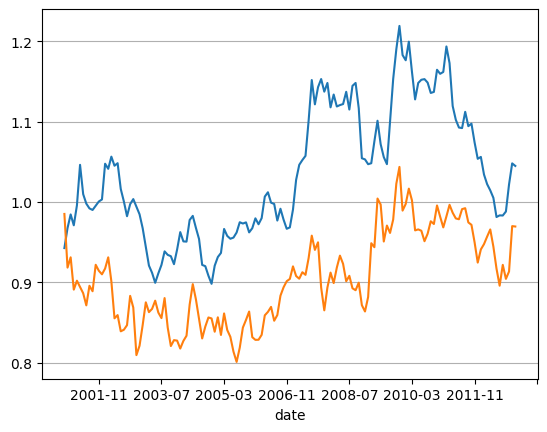

In [86]:
portfolio_ff3_disparity, portfolio_table11_disparity = make_portfolio(unionn)

portfolio_ff3_disparity.set_index('date')['cum_alpha_ew'].plot().grid(axis='y')
portfolio_ff3_disparity.set_index('date')['cum_alpha_vw'].plot().grid(axis='y')

In [87]:
# con.execute('''
#     create or replace table figure2and3 as
#     select 
#         portfolio_ff3_own_firm.date, 
#         portfolio_ff3_own_firm.cum_alpha_ew as ew_own,
#         portfolio_ff3_own_firm.cum_alpha_vw as vw_own,
#         portfolio_ff3_hm.cum_alpha_ew as ew_hm,
#         portfolio_ff3_hm.cum_alpha_vw as vw_hm,
#         portfolio_ff3_sm.cum_alpha_ew as ew_sm,
#         portfolio_ff3_sm.cum_alpha_vw as vw_sm,
#         portfolio_ff3_disparity.cum_alpha_ew as ew_disparity,
#         portfolio_ff3_disparity.cum_alpha_vw as vw_disparity
#     from portfolio_ff3_own_firm
#     inner join portfolio_ff3_hm
#         on portfolio_ff3_own_firm.date = portfolio_ff3_hm.date
#     inner join portfolio_ff3_sm
#         on portfolio_ff3_own_firm.date = portfolio_ff3_sm.date
#     inner join portfolio_ff3_disparity
#         on portfolio_ff3_own_firm.date = portfolio_ff3_disparity.date
# ''')

con.execute('''
    create or replace table figure2and3 as
    select 
        portfolio_ff3_own_firm.date, 
        portfolio_ff3_own_firm.cum_ew as ew_own,
        portfolio_ff3_own_firm.cum_vw as vw_own,
        portfolio_ff3_hm.cum_ew as ew_hm,
        portfolio_ff3_hm.cum_vw as vw_hm,
        portfolio_ff3_sm.cum_ew as ew_sm,
        portfolio_ff3_sm.cum_vw as vw_sm,
        portfolio_ff3_disparity.cum_ew as ew_disparity,
        portfolio_ff3_disparity.cum_vw as vw_disparity
    from portfolio_ff3_own_firm
    inner join portfolio_ff3_hm
        on portfolio_ff3_own_firm.date = portfolio_ff3_hm.date
    inner join portfolio_ff3_sm
        on portfolio_ff3_own_firm.date = portfolio_ff3_sm.date
    inner join portfolio_ff3_disparity
        on portfolio_ff3_own_firm.date = portfolio_ff3_disparity.date
''')



In [88]:
figure2and3 = con.execute('''
    select *
    from figure2and3
    order by date
''').fetch_df()

figure2and3

,date,ew_own,vw_own,ew_hm,vw_hm,ew_sm,vw_sm,ew_disparity,vw_disparity
0,1998-07,1.036940,1.121131,1.034726,0.989191,1.009257,0.989475,0.990566,0.924925
1,1998-08,1.065361,1.186122,1.060161,1.062133,0.973813,0.992292,0.933168,0.815009
2,1998-09,1.096751,1.102953,1.022740,0.940230,1.057182,1.081196,0.926585,0.763010
3,1998-10,1.008417,0.978895,0.930805,0.860421,1.038293,1.009072,0.912930,0.768325
4,1998-11,1.017335,1.047897,0.965118,0.952367,1.095229,1.030440,0.961652,0.792382
...,...,...,...,...,...,...,...,...,...
169,2012-08,0.758560,1.625060,3.254487,0.875589,4.687604,0.796700,1.394346,1.139922
170,2012-09,0.750622,1.602145,3.253870,0.858768,4.739240,0.799675,1.404552,1.123859
171,2012-10,0.781722,1.531174,3.378372,0.856079,4.614054,0.808433,1.442939,1.116576
172,2012-11,0.777534,1.547109,3.388254,0.852750,4.600805,0.795290,1.485630,1.193863


In [89]:
figure2and3.duplicated(subset=['date']).sum()

0

# Table 1

In [90]:
statistics_t1 = [
    'Mean',
    'Std. Dev.',
    'Minimum',
    'Median',
    'Maximum'
]

In [91]:
# panel A

df_A = pd.DataFrame(
    {
        'Monthly Return': msf['ret'], 
        'Log B/M Ratio': msf['log_bm'], 
        'Log Market Cap': msf['log_mcap'], 
        'Month t-1 Past Return': msf['ret_lag1'],
        'Month t-2 to t-12 Past Return': own_firm['rollret_11']
    }
)

df_A = df_A.apply(table1).transpose()
df_A.columns = statistics_t1

df_A

,Mean,Std. Dev.,Minimum,Median,Maximum
Monthly Return,0.009902,0.177449,-0.981295,0.001603,13.495050
Log B/M Ratio,-0.662594,0.869036,-13.167480,-0.581258,12.449392
Log Market Cap,12.601365,2.036410,5.534969,12.473953,20.255740
Month t-1 Past Return,0.015444,0.187805,-0.877551,0.003125,13.495050
Month t-2 to t-12 Past Return,0.119426,0.733067,-0.994822,0.025160,49.980391


In [92]:
# panel B

df_B = pd.DataFrame(
    {
        'Month t-1 Past Return': hm_1['rollret_1'],
        'Month t-1 to t-3 Past Return': hm_1['rollret_3'],
        'Month t-1 to t-6 Past Return': hm_1['rollret_6'],
        'Month t-1 to t-12 Past Return': hm_1['rollret_12']
    }
)

df_B = df_B.apply(table1).transpose()
df_B.columns = statistics_t1

df_B

,Mean,Std. Dev.,Minimum,Median,Maximum
Month t-1 Past Return,0.009318,0.099987,-0.828767,0.009285,3.958333
Month t-1 to t-3 Past Return,0.030171,0.195525,-0.915644,0.024612,14.111111
Month t-1 to t-6 Past Return,0.064551,0.295888,-0.955208,0.044487,15.238023
Month t-1 to t-12 Past Return,0.137521,0.465917,-0.971670,0.080256,17.118022


In [93]:
# panel C


df_C = pd.DataFrame(
    {
        'Month t-1 Past Return': sm_1['rollret_1'],
        'Month t-1 to t-3 Past Return': sm_1['rollret_3'],
        'Month t-1 to t-6 Past Return': sm_1['rollret_6'],
        'Month t-1 to t-12 Past Return': sm_1['rollret_12']
    }
)

df_C = df_C.apply(table1).transpose()
df_C.columns = statistics_t1

df_C

,Mean,Std. Dev.,Minimum,Median,Maximum
Month t-1 Past Return,0.005319,0.069555,-0.467422,0.008962,0.677791
Month t-1 to t-3 Past Return,0.015973,0.123037,-0.710451,0.024132,1.168943
Month t-1 to t-6 Past Return,0.033873,0.176778,-0.795158,0.037159,1.736185
Month t-1 to t-12 Past Return,0.071962,0.257587,-0.781766,0.074980,2.657445


In [94]:
# panel D

df_D = pd.DataFrame(
    {
        'Month t Own-Firm Return': msf['ret'],
        'Log Book to Market Ratio': msf['log_bm'],
        'B/M Ratio': msf['bm'],
        'Log Mkt Capitalization': msf['log_mcap'],
        'Month t − 1 Own-Firm Return': msf['ret_lag1'],
        'Month t − 1 FF–48 Return': sm_1['rollret_1'],
        'Month t − 1 TNIC–3 Return': hm_1['rollret_1']
    }
)

df_D = df_D.corr(method='pearson')

df_D = df_D.loc[
    ['B/M Ratio', 
     'Log Mkt Capitalization', 
     'Month t − 1 Own-Firm Return', 
     'Month t − 1 FF–48 Return', 
     'Month t − 1 TNIC–3 Return'
    ], 
    ['Month t Own-Firm Return', 
     'Log Book to Market Ratio',
     'Log Mkt Capitalization',
     'Month t − 1 Own-Firm Return',
     'Month t − 1 FF–48 Return'
    ]
]

df_D

,Month t Own-Firm Return,Log Book to Market Ratio,Log Mkt Capitalization,Month t − 1 Own-Firm Return,Month t − 1 FF–48 Return
B/M Ratio,0.000051,0.067025,0.007362,-0.000113,0.000705
Log Mkt Capitalization,0.062343,-0.315100,1.000000,0.020256,0.001117
Month t − 1 Own-Firm Return,0.008949,0.037040,0.020256,1.000000,0.002406
Month t − 1 FF–48 Return,0.000668,-0.000124,0.001117,0.002406,1.000000
Month t − 1 TNIC–3 Return,0.002691,0.001298,-0.000344,0.001842,-0.003254


In [95]:
df_table1 = pd.concat([df_A, df_B, df_C], axis=0)
df_table1

,Mean,Std. Dev.,Minimum,Median,Maximum
Monthly Return,0.009902,0.177449,-0.981295,0.001603,13.495050
Log B/M Ratio,-0.662594,0.869036,-13.167480,-0.581258,12.449392
Log Market Cap,12.601365,2.036410,5.534969,12.473953,20.255740
Month t-1 Past Return,0.015444,0.187805,-0.877551,0.003125,13.495050
Month t-2 to t-12 Past Return,0.119426,0.733067,-0.994822,0.025160,49.980391
Month t-1 Past Return,0.009318,0.099987,-0.828767,0.009285,3.958333
Month t-1 to t-3 Past Return,0.030171,0.195525,-0.915644,0.024612,14.111111
Month t-1 to t-6 Past Return,0.064551,0.295888,-0.955208,0.044487,15.238023
Month t-1 to t-12 Past Return,0.137521,0.465917,-0.971670,0.080256,17.118022
Month t-1 Past Return,0.005319,0.069555,-0.467422,0.008962,0.677791


# Table 11

In [96]:
statistics_t11 = [
    'Alpha',
    'MKT',
    'HML',
    'SMB',
    'UMD',
    'Sharpe Ratios',
    'R square',
    'Obs.'
]

In [103]:
# panel A

portfolio_table11_disparity_2008 = portfolio_table11_disparity[portfolio_table11_disparity['date'] >= '2008-01']
portfolio_table11_disparity_2008.reset_index(drop=True, inplace=True)

df_A_dict = {
    'All Months t-1 to t-12 Momentum long': portfolio_table11_disparity[['date', 'ew_long']], 
    'All Months t-1 to t-12 Momentum short': portfolio_table11_disparity[['date', 'ew_short']],
    'Pre-2008 t-1 to t-12 Momentum long': portfolio_table11_disparity_2008[['date', 'ew_long']], 
    'Pre-2008 t-1 to t-12 Momentum short': portfolio_table11_disparity_2008[['date', 'ew_short']]
}

df_A = pd.DataFrame()

for col_name, df in df_A_dict.items():
    df.columns = ['date', col_name]
    df_A[col_name] = table11(df, yvar=col_name)

df_A = df_A.transpose()
df_A.columns = statistics_t11

df_A

,Alpha,MKT,HML,SMB,UMD,Sharpe Ratios,R square,Obs.
All Months t-1 to t-12 Momentum long,0.004427,0.873981,0.218546,0.812841,-0.132004,0.496861,0.903567,174.0
All Months t-1 to t-12 Momentum short,-0.002583,-0.684151,-0.455376,-0.345562,0.095290,-0.462924,0.823949,174.0
Pre-2008 t-1 to t-12 Momentum long,0.000062,0.978685,-0.004547,0.812537,-0.127196,0.293338,0.966307,60.0
Pre-2008 t-1 to t-12 Momentum short,-0.000302,-0.764196,-0.285733,-0.316648,0.099253,-0.242233,0.864829,60.0


In [104]:
# panel B

portfolio_table11_hm_2008 = portfolio_table11_hm[portfolio_table11_hm['date'] >= '2008-01']
portfolio_table11_hm_2008.reset_index(drop=True, inplace=True)

df_B_dict = {
    'All Months t-1 to t-12 Momentum long': portfolio_table11_hm[['date', 'ew_long']], 
    'All Months t-1 to t-12 Momentum short': portfolio_table11_hm[['date', 'ew_short']],
    'Pre-2008 t-1 to t-12 Momentum long': portfolio_table11_hm_2008[['date', 'ew_long']], 
    'Pre-2008 t-1 to t-12 Momentum short': portfolio_table11_hm_2008[['date', 'ew_short']]
}

df_B = pd.DataFrame()

for col_name, df in df_B_dict.items():
    df.columns = ['date', col_name]
    df_B[col_name] = table11(df, yvar=col_name)

df_B = df_B.transpose()
df_B.columns = statistics_t11

df_B

,Alpha,MKT,HML,SMB,UMD,Sharpe Ratios,R square,Obs.
All Months t-1 to t-12 Momentum long,0.008736,1.147118,0.000124,1.139249,0.452692,0.712998,0.876087,174.0
All Months t-1 to t-12 Momentum short,-0.004979,-0.977795,-0.247200,-0.925255,0.763414,-0.268396,0.904808,174.0
Pre-2008 t-1 to t-12 Momentum long,0.001016,1.197548,-0.073984,0.778812,0.285701,0.256569,0.898254,60.0
Pre-2008 t-1 to t-12 Momentum short,0.002355,-0.948593,-0.173558,-1.194339,0.699814,-0.247933,0.930659,60.0


In [105]:
# panel C

portfolio_table11_sm_2008 = portfolio_table11_sm[portfolio_table11_sm['date'] >= '2008-01']
portfolio_table11_sm_2008.reset_index(drop=True, inplace=True)

df_C_dict = {
    'All Months t-1 to t-12 Momentum long': portfolio_table11_sm[['date', 'ew_long']], 
    'All Months t-1 to t-12 Momentum short': portfolio_table11_sm[['date', 'ew_short']],
    'Pre-2008 t-1 to t-12 Momentum long': portfolio_table11_sm_2008[['date', 'ew_long']], 
    'Pre-2008 t-1 to t-12 Momentum short': portfolio_table11_sm_2008[['date', 'ew_short']]
}

df_C = pd.DataFrame()

for col_name, df in df_C_dict.items():
    df.columns = ['date', col_name]
    df_C[col_name] = table11(df, yvar=col_name)

df_C = df_C.transpose()
df_C.columns = statistics_t11

df_C

,Alpha,MKT,HML,SMB,UMD,Sharpe Ratios,R square,Obs.
All Months t-1 to t-12 Momentum long,0.010416,1.083574,0.156234,1.016587,0.220644,0.789195,0.821199,174.0
All Months t-1 to t-12 Momentum short,-0.004915,-0.844989,-0.199980,-0.775486,0.536337,-0.333282,0.860747,174.0
Pre-2008 t-1 to t-12 Momentum long,0.002660,1.069743,-0.157921,0.840063,-0.018018,0.381799,0.843599,60.0
Pre-2008 t-1 to t-12 Momentum short,-0.000792,-0.703760,-0.619184,-0.805351,0.237620,-0.314024,0.943429,60.0


In [106]:
# panel D

portfolio_table11_own_firm_2008 = portfolio_table11_own_firm[portfolio_table11_own_firm['date'] >= '2008-01']
portfolio_table11_own_firm_2008.reset_index(drop=True, inplace=True)

df_D_dict = {
    'All Months t-1 to t-12 Momentum long': portfolio_table11_own_firm[['date', 'ew_long']], 
    'All Months t-1 to t-12 Momentum short': portfolio_table11_own_firm[['date', 'ew_short']],
    'Pre-2008 t-1 to t-12 Momentum long': portfolio_table11_own_firm_2008[['date', 'ew_long']], 
    'Pre-2008 t-1 to t-12 Momentum short': portfolio_table11_own_firm_2008[['date', 'ew_short']]
}

df_D = pd.DataFrame()

for col_name, df in df_D_dict.items():
    df.columns = ['date', col_name]
    df_D[col_name] = table11(df, yvar=col_name)

df_D = df_D.transpose()
df_D.columns = statistics_t11

df_D

,Alpha,MKT,HML,SMB,UMD,Sharpe Ratios,R square,Obs.
All Months t-1 to t-12 Momentum long,0.005735,1.268709,-0.045040,0.962604,0.453655,0.593936,0.935687,174.0
All Months t-1 to t-12 Momentum short,-0.008885,-1.091646,-0.090277,-1.287967,0.918076,-0.344773,0.864912,174.0
Pre-2008 t-1 to t-12 Momentum long,-0.002386,1.286884,-0.006968,0.722608,0.358366,0.087643,0.964252,60.0
Pre-2008 t-1 to t-12 Momentum short,0.000632,-0.992281,-0.297577,-1.168989,0.856872,-0.294067,0.895676,60.0


In [107]:
df_table11 = pd.concat([df_A, df_B, df_C, df_D], axis=0)
df_table11

,Alpha,MKT,HML,SMB,UMD,Sharpe Ratios,R square,Obs.
All Months t-1 to t-12 Momentum long,0.004427,0.873981,0.218546,0.812841,-0.132004,0.496861,0.903567,174.0
All Months t-1 to t-12 Momentum short,-0.002583,-0.684151,-0.455376,-0.345562,0.095290,-0.462924,0.823949,174.0
Pre-2008 t-1 to t-12 Momentum long,0.000062,0.978685,-0.004547,0.812537,-0.127196,0.293338,0.966307,60.0
Pre-2008 t-1 to t-12 Momentum short,-0.000302,-0.764196,-0.285733,-0.316648,0.099253,-0.242233,0.864829,60.0
All Months t-1 to t-12 Momentum long,0.008736,1.147118,0.000124,1.139249,0.452692,0.712998,0.876087,174.0
All Months t-1 to t-12 Momentum short,-0.004979,-0.977795,-0.247200,-0.925255,0.763414,-0.268396,0.904808,174.0
Pre-2008 t-1 to t-12 Momentum long,0.001016,1.197548,-0.073984,0.778812,0.285701,0.256569,0.898254,60.0
Pre-2008 t-1 to t-12 Momentum short,0.002355,-0.948593,-0.173558,-1.194339,0.699814,-0.247933,0.930659,60.0
All Months t-1 to t-12 Momentum long,0.010416,1.083574,0.156234,1.016587,0.220644,0.789195,0.821199,174.0
All Months t-1 to t-12 Momentum short,-0.004915,-0.844989,-0.199980,-0.775486,0.536337,-0.333282,0.860747,174.0


# Figure 2

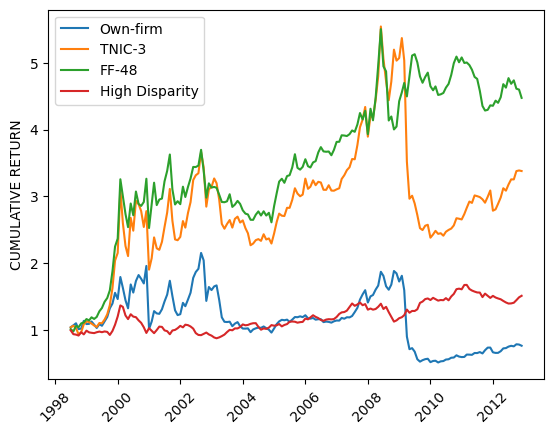

In [108]:
fig, ax = plt.subplots()
ax.plot_date(pd.to_datetime(figure2and3['date']), figure2and3['ew_own'], marker='', linestyle='-', label='Own-firm')
ax.plot_date(pd.to_datetime(figure2and3['date']), figure2and3['ew_hm'], marker='', linestyle='-', label='TNIC-3')
ax.plot_date(pd.to_datetime(figure2and3['date']), figure2and3['ew_sm'], marker='', linestyle='-', label='FF-48')
ax.plot_date(pd.to_datetime(figure2and3['date']), figure2and3['ew_disparity'], marker='', linestyle='-', label='High Disparity')
plt.legend()
plt.ylabel('CUMULATIVE RETURN')
plt.tick_params(axis='x', rotation=45)
plt.show()

# Figure 3

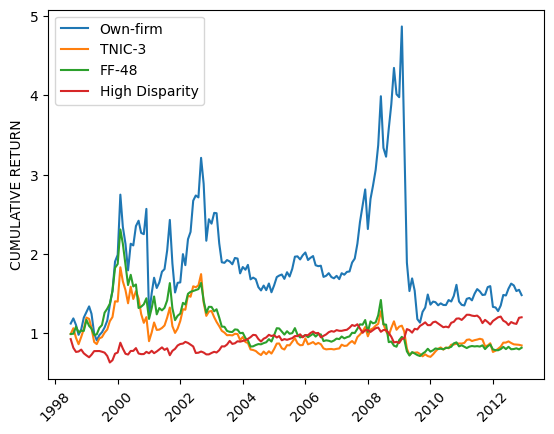

In [109]:
fig, ax = plt.subplots()
ax.plot_date(pd.to_datetime(figure2and3['date']), figure2and3['vw_own'], marker='', linestyle='-', label='Own-firm')
ax.plot_date(pd.to_datetime(figure2and3['date']), figure2and3['vw_hm'], marker='', linestyle='-', label='TNIC-3')
ax.plot_date(pd.to_datetime(figure2and3['date']), figure2and3['vw_sm'], marker='', linestyle='-', label='FF-48')
ax.plot_date(pd.to_datetime(figure2and3['date']), figure2and3['vw_disparity'], marker='', linestyle='-', label='High Disparity')
plt.legend()
plt.ylabel('CUMULATIVE RETURN')
plt.tick_params(axis='x', rotation=45)
plt.show()
